In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.2'

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X, y, test_size=0.2, random_state=27)

X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

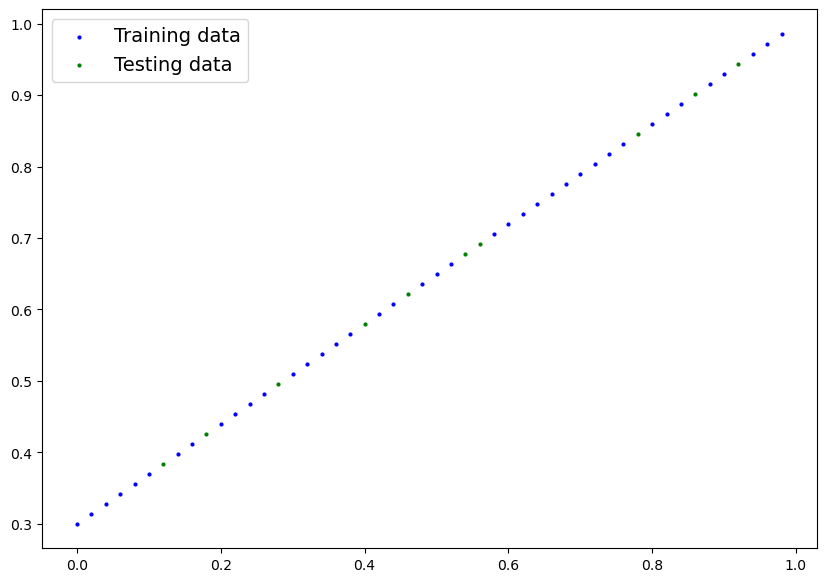

In [10]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})
    
plot_predictions();

In [11]:
# Create a Linear Regression model class

# vvv- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
class LinearRegressionModel(nn.Module): 
    def __init__(self):
        super().__init__() 
        
        # v- start with random weights (this will get adjusted as the model learns)
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float)# <- PyTorch loves float32 by default
            , requires_grad=True) # <- can we update this value with gradient descent?)
        
        # v- start with random bias (this will get adjusted as the model learns)
        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float)# <- PyTorch loves float32 by default
            , requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. train/test features)   
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


In [14]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [20]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [21]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.2231],
        [0.2635],
        [0.4386],
        [0.4184],
        [0.1692],
        [0.1894],
        [0.3106],
        [0.2837],
        [0.3174],
        [0.3914]])


In [22]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters() # parameters of target model to optimize                        
    , lr=0.01
) 
# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

In [28]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 250

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

LinearRegressionModel()

LinearRegressionModel()

Epoch: 0 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 10 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 20 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 30 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 40 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 50 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 60 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 70 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 80 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 90 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 100 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 110 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 120 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 130 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 140 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 150 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 160 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 170 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 180 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 190 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 200 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 210 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 220 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 230 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 240 | MAE Train Loss: 0.005144170019775629 | MAE Test Loss: 0.007228591945022345 


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

In [30]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

LinearRegressionModel()

LinearRegressionModel()

Epoch: 0 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 10 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 20 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 30 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 40 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 50 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 60 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 70 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 80 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 90 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 100 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 110 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 120 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 130 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 140 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 150 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 160 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 170 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 180 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

Epoch: 190 | Loss: 0.005144170019775629 | Test loss: 0.007228591945022345
OrderedDict([('weights', tensor([0.7008])), ('bias', tensor([0.3068]))])


LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

LinearRegressionModel()

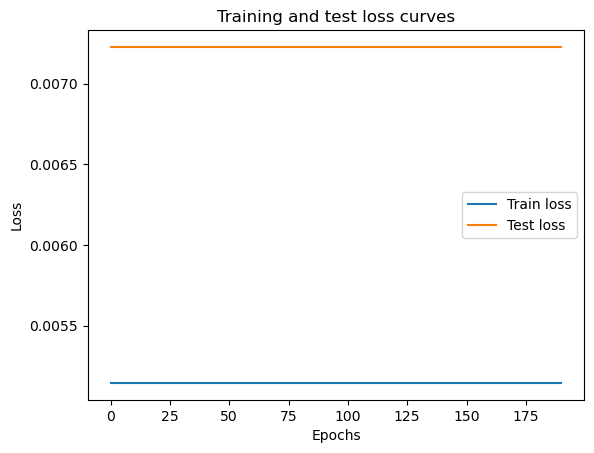

In [31]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();